## Detailed article explaination
The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/542629/openai-gpt-4o-vs-claude-3-5-sonnet-for-multi-label-text-classification

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Installing and Importing Required Libraries

In [ ]:

!pip install anthropic
!pip install openai


  Using cached anthropic-0.39.0-py3-none-any.whl.metadata (22 kB)
Using cached anthropic-0.39.0-py3-none-any.whl (198 kB)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
from sklearn.metrics import hamming_loss, accuracy_score

import anthropic
from openai import OpenAI

from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

## Importing and Visualizing the Dataset

In [ ]:
## dataset download link
## https://www.kaggle.com/datasets/shivanandmn/multilabel-classification-dataset?select=train.csv

dataset = pd.read_csv("/content/train.csv")
print(f"Dataset Shape: {dataset.shape}")
dataset.head()

Dataset Shape: (20972, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:

subjects = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
filtered_dataset = dataset[(dataset[subjects] == 1).sum(axis=1) >= 2]
print(f"Filtered Dataset Shape: {filtered_dataset.shape}")
filtered_dataset.head()

Filtered Dataset Shape: (5044, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
21,22,Many-Body Localization: Stability and Instability,Rare regions with weak disorder (Griffiths r...,0,1,1,0,0,0
28,29,Minimax Estimation of the $L_1$ Distance,We consider the problem of estimating the $L...,0,0,1,1,0,0
29,30,Density large deviations for multidimensional ...,We investigate the density large deviation f...,0,1,1,0,0,0
30,31,mixup: Beyond Empirical Risk Minimization,"Large deep neural networks are powerful, but...",1,0,0,1,0,0


<ipython-input-6-57e32386af47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset[subjects] = filtered_dataset[subjects].astype(int)


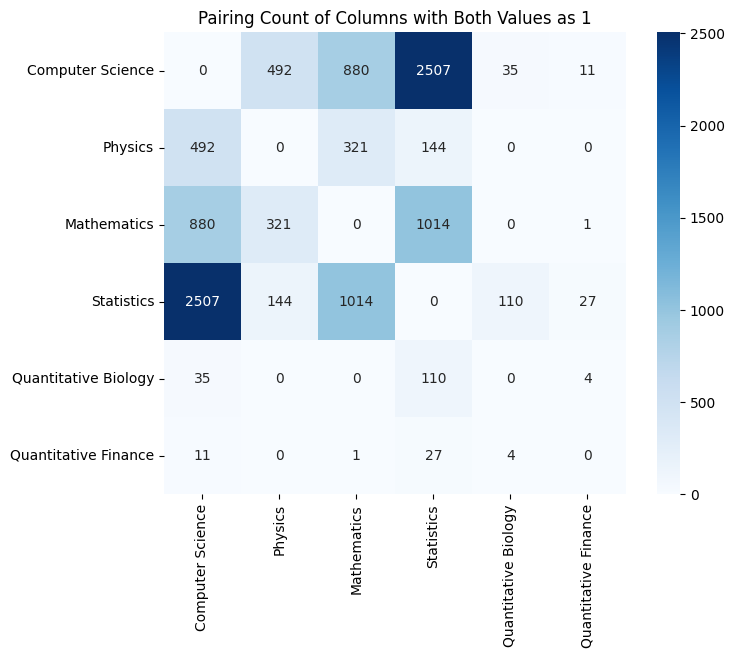

In [ ]:
filtered_dataset[subjects] = filtered_dataset[subjects].astype(int)

pair_counts = {pair: 0 for pair in combinations(subjects, 2)}

# Count occurrences where both subjects in each pair have a value of 1
for subject1, subject2 in pair_counts:
    pair_counts[(subject1, subject2)] = ((filtered_dataset[subject1] == 1) & (filtered_dataset[subject2] == 1)).sum()

# Convert the pair counts to a DataFrame suitable for a heatmap
pair_counts_df = pd.DataFrame(0, index=subjects, columns=subjects)
for (subject1, subject2), count in pair_counts.items():
    pair_counts_df.loc[subject1, subject2] = count
    pair_counts_df.loc[subject2, subject1] = count  # Ensure symmetry

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pair_counts_df,
            annot=True,
            fmt="d",
            cmap="Blues",
            square=True,
            cbar=True)

plt.title("Pairing Count of Columns with Both Values as 1")
plt.show()

## Zero-Shot Multilable Text Classification

In [ ]:

def find_research_category(client, model, dataset):

    outputs = []
    i = 0

    for _, row in sampled_df.iterrows():
        title = row['TITLE']
        abstract = row['ABSTRACT']

        content = """You are an expert in various scientific domains.
                     Given the following research paper title and abstract, classify the research paper into at least two or more of the following categories:
                    - Computer Science
                    - Physics
                    - Mathematics
                    - Statistics
                    - Quantitative Biology
                    - Quantitative Finance

                    Return only a comma-separated list of the categories (e.g., [Computer Science,Physics] or [Computer Science,Physics,Mathematics]).
                    Use the exact case sensitivity and spelling of the categories provided above.

                    text: Title: {}\nAbstract: {}""".format(title, abstract)


        research_category = ""

        if model == "gpt-4o":

          research_category = client.chat.completions.create(
                                model= model,
                                temperature = 0,
                                max_tokens = 100,
                                messages=[
                                      {"role": "user", "content": content}
                                  ]
                              ).choices[0].message.content


        if model == "claude-3-5-sonnet-20241022":

          research_category = client.messages.create(
                                model= model,
                                max_tokens=10,
                                temperature=0.0,
                                messages=[
                                    {"role": "user", "content": content}
                                ]
                            ).content[0].text

        outputs.append(research_category)
        print(i + 1, research_category)
        i += 1

    return outputs

In [ ]:

def parse_outputs_to_dataframe(outputs):

    subjects = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
    # Remove square brackets and split the subjects for each entry in outputs
    parsed_data = [item.strip('[]').split(',') for item in outputs]

    # Create an empty DataFrame with columns for each subject, initializing with 0s
    df = pd.DataFrame(0, index=range(len(parsed_data)), columns=subjects)

    # Populate the DataFrame with 1s based on the presence of each subject in each row
    for i, subjects_list in enumerate(parsed_data):
        for subject in subjects_list:
            if subject in subjects:
                df.loc[i, subject] = 1

    return df


In [ ]:
sampled_df = filtered_dataset.sample(n=100, random_state=42)

### Multi-label Text Classification with GPT-4o

In [ ]:
client = OpenAI(api_key = OPENAI_API_KEY,)
model = "gpt-4o"

outputs = find_research_category(client, model, sampled_df)



1 [Physics,Mathematics]
2 [Statistics]
3 [Computer Science, Statistics]
4 [Statistics,Mathematics]
5 [Computer Science,Statistics]
6 [Statistics]
7 [Computer Science,Mathematics]
8 [Statistics,Quantitative Finance]
9 [Computer Science,Mathematics]
10 [Computer Science,Mathematics]
11 [Computer Science,Statistics]
12 [Computer Science,Statistics]
13 [Computer Science,Physics]
14 [Computer Science,Statistics]
15 [Computer Science,Statistics]
16 [Statistics,Quantitative Biology]
17 [Statistics,Mathematics]
18 [Statistics,Quantitative Biology]
19 [Computer Science, Statistics]
20 [Mathematics]
21 [Statistics,Quantitative Biology]
22 [Mathematics]
23 [Statistics,Mathematics]
24 [Computer Science]
25 [Mathematics,Statistics]
26 [Computer Science,Statistics]
27 [Computer Science, Quantitative Biology]
28 [Computer Science,Quantitative Biology]
29 [Physics,Mathematics]
30 [Computer Science,Statistics]
31 [Computer Science,Mathematics,Statistics]
32 [Statistics, Quantitative Finance]
33 [Comput

In [ ]:
predictions = parse_outputs_to_dataframe(outputs)
targets = sampled_df[subjects]

# Calculate Hamming Loss
hamming = hamming_loss(targets, predictions)
print(f"Hamming Loss: {hamming}")

# Calculate Subset Accuracy (Exact Match Ratio)
subset_accuracy = accuracy_score(targets, predictions)
print(f"Subset Accuracy: {subset_accuracy}")


Hamming Loss: 0.16
Subset Accuracy: 0.4


## Multilable Text Classification with Claude 3.5 Sonnet

In [ ]:
client = anthropic.Anthropic(api_key = ANTHROPIC_API_KEY)
model = "claude-3-5-sonnet-20241022"

outputs = find_research_category(client, model, sampled_df)

1 [Physics,Mathematics]
2 [Mathematics,Statistics]
3 [Computer Science,Mathematics,Statistics]
4 [Mathematics,Statistics]
5 [Computer Science,Mathematics,Statistics]
6 [Mathematics,Statistics]
7 [Computer Science,Mathematics,Statistics]
8 [Computer Science,Statistics,Quantitative Finance
9 [Computer Science,Mathematics,Statistics]
10 [Computer Science,Mathematics]
11 [Computer Science,Statistics]
12 [Computer Science,Mathematics,Statistics]
13 [Computer Science,Physics,Statistics]
14 [Computer Science,Mathematics,Statistics]
15 [Computer Science,Mathematics,Statistics]
16 [Statistics,Mathematics]
17 [Mathematics,Statistics,Physics]
18 [Computer Science,Statistics]
19 [Computer Science,Mathematics,Statistics]
20 [Mathematics,Computer Science]
21 [Mathematics,Statistics,Quantitative Biology]
22 [Mathematics]
23 [Mathematics,Statistics]
24 [Computer Science,Mathematics]
25 [Mathematics,Statistics]
26 [Computer Science,Mathematics,Statistics]
27 [Computer Science,Mathematics,Statistics]
28

In [ ]:
predictions = parse_outputs_to_dataframe(outputs)
targets = sampled_df[subjects]

# Calculate Hamming Loss
hamming = hamming_loss(targets, predictions)
print(f"Hamming Loss: {hamming}")

# Calculate Subset Accuracy (Exact Match Ratio)
subset_accuracy = accuracy_score(targets, predictions)
print(f"Subset Accuracy: {subset_accuracy}")

Hamming Loss: 0.17166666666666666
Subset Accuracy: 0.29
